In [1]:
import pandas as pd

In [2]:
data=pd.read_csv(r"C:\Users\Public\project\data\data.csv")

In [3]:
data.head(2)

,index,Date,Close,High,Low,Open,Volume
0,0,2015-01-01,1.209863,1.209863,1.209863,1.209863,0
1,1,2015-01-02,1.208941,1.208956,1.201080,1.208868,0


In [4]:
data['return']=data['Close'].pct_change()

import numpy as np

data['log_return'] = np.log(data['Close'] / data['Close'].shift(1))

data=data.dropna()

data.head()

,index,Date,Close,High,Low,Open,Volume,return,log_return
1,1,2015-01-02,1.208941,1.208956,1.201080,1.208868,0,-0.000762,-0.000762
2,2,2015-01-05,1.194643,1.197590,1.188909,1.195500,0,-0.011827,-0.011897
3,3,2015-01-06,1.193902,1.197000,1.188693,1.193830,0,-0.000621,-0.000621
4,4,2015-01-07,1.187536,1.190000,1.180401,1.187479,0,-0.005332,-0.005346
5,5,2015-01-08,1.183600,1.184806,1.175601,1.183894,0,-0.003314,-0.003320


<Axes: >

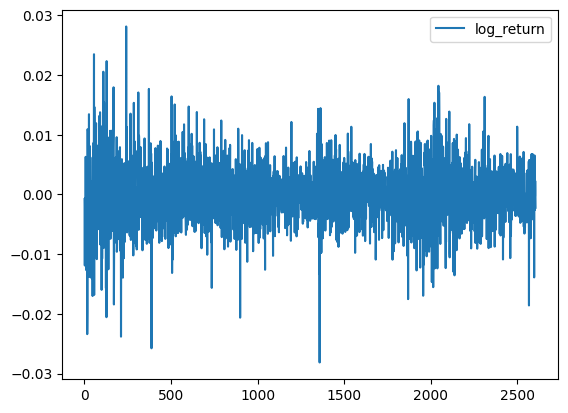

In [5]:
data[['Date','log_return']].plot()



In [6]:
len(data)

2605

In [7]:
df=data['log_return']

In [8]:
data['log_return'].mean()

-5.784833413480269e-05

<Axes: xlabel='log_return', ylabel='Count'>

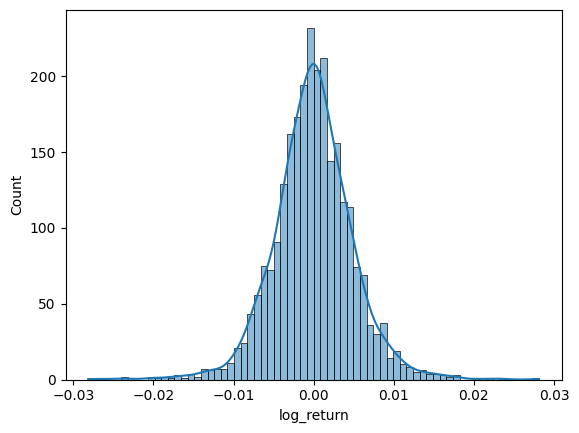

In [9]:
import seaborn as sns
sns.histplot(df,kde=True)

{'whiskers': [<matplotlib.lines.Line2D at 0x26ccb9cf790>,
 'caps': [<matplotlib.lines.Line2D at 0x26ccb9ed030>,
 'boxes': [<matplotlib.lines.Line2D at 0x26ccb9ec850>],
 'medians': [<matplotlib.lines.Line2D at 0x26ccb9ed630>],
 'fliers': [<matplotlib.lines.Line2D at 0x26ccb9ed930>],
 'means': []}

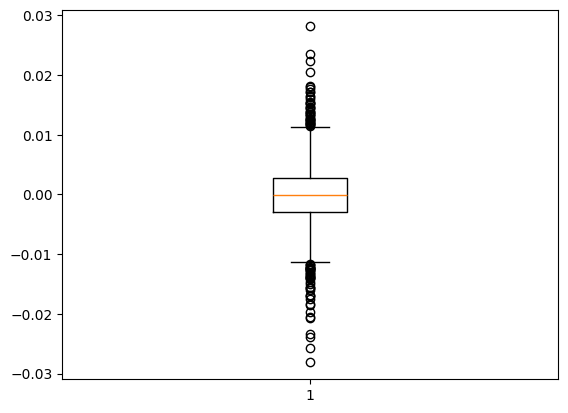

In [10]:
import matplotlib.pyplot as plt

plt.boxplot(df)

In [11]:
# Step 1: Compute Q1, Q3, IQR
Q1 = df.quantile(0.25)
Q3 = df.quantile(0.75)
IQR = Q3 - Q1

# Step 2: Compute bounds
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Step 3: Filter out outliers
outlier = df[((df < lower_bound) | (df > upper_bound))]
df_clean = df[(df >= lower_bound) & (df <= upper_bound)]

print(df_clean.dtype)
df_clean=df_clean.reset_index()

df_clean

float64


,index,log_return
0,1,-0.000762
1,3,-0.000621
2,4,-0.005346
3,5,-0.003320
4,6,-0.003379
...,...,...
2519,2601,-0.000312
2520,2602,-0.000291
2521,2603,0.002270
2522,2604,0.000594


In [12]:
len(df_clean)

2524

In [13]:
len(outlier)

81

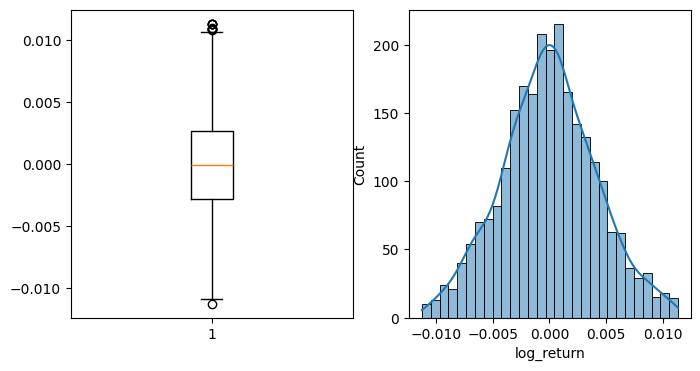

In [14]:
#after outlier removal
plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.boxplot(df_clean['log_return'])
plt.subplot(1,2,2)
sns.histplot(df_clean['log_return'],kde=True)
plt.show()

In [15]:
df_clean.head()

,index,log_return
0,1,-0.000762
1,3,-0.000621
2,4,-0.005346
3,5,-0.003320
4,6,-0.003379


In [16]:
from sklearn.preprocessing import StandardScaler

scaler=StandardScaler()
data_scaled=scaler.fit_transform(df_clean.values.reshape(-1,1))

In [17]:

data_scaled

array([[-0.77930723],
       [-0.78049567],
       [-0.77693215],
       ...,
       [-0.78049406],
       [ 2.31303996],
       [-0.78049741]])

In [18]:
data_scaled.dtype

dtype('float64')

# Model1: LSTM

In [19]:
X = []
Y = []

input_sequence=20
for i in range(len(data_scaled) - input_sequence):
    X.append(data_scaled[i : i + input_sequence])
    Y.append(data_scaled[i + input_sequence])

X = np.array(X)
Y = np.array(Y)


In [20]:
train_size=int(len(X)*0.7)
val_size=int(len(X)*0.15)
test_size=train_size-val_size

X_train,Y_train=X[:train_size],Y[:train_size]

#test data
X_test,Y_test=X[train_size:train_size+val_size],Y[train_size:train_size+val_size]

#validation data
X_val,Y_val=X[train_size+val_size:],Y[train_size+val_size:]


In [21]:
len(X_train)

3519

In [22]:
from tensorflow.keras.layers import *
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError

In [23]:

n_feature=1
n_input=20



model_LSTM=Sequential()
model_LSTM.add(InputLayer(input_shape=(n_input, n_feature)))
model_LSTM.add(LSTM(45,return_sequences=True))
model_LSTM.add(Dropout(0.2))
model_LSTM.add(LSTM(16))
model_LSTM.add(Dropout(0.2))
model_LSTM.add(Dense(3,activation='relu'))
model_LSTM.add(Dense(1,activation='linear'))

C:\Users\elham\anaconda3\envs\torchenv\lib\site-packages\keras\src\layers\core\input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


In [24]:
early_stopping=EarlyStopping(monitor='val_loss',patience=2,restore_best_weights=True)
model_LSTM.compile(optimizer=Adam(learning_rate=0.0001),loss=MeanSquaredError(),metrics=[RootMeanSquaredError()])

In [25]:
hist=model_LSTM.fit(X_train,Y_train,epochs=32,batch_size=32,callbacks=[early_stopping],
               validation_data=(X_val,Y_val),verbose=1)

Epoch 1/32
110/110 ━━━━━━━━━━━━━━━━━━━━ 13s 38ms/step - loss: 0.5385 - root_mean_squared_error: 0.7337 - val_loss: 2.3867 - val_root_mean_squared_error: 1.5449
Epoch 2/32
110/110 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - loss: 0.4510 - root_mean_squared_error: 0.6714 - val_loss: 2.1890 - val_root_mean_squared_error: 1.4795
Epoch 3/32
110/110 ━━━━━━━━━━━━━━━━━━━━ 5s 48ms/step - loss: 0.4034 - root_mean_squared_error: 0.6350 - val_loss: 2.0211 - val_root_mean_squared_error: 1.4217
Epoch 4/32
110/110 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - loss: 0.3752 - root_mean_squared_error: 0.6124 - val_loss: 1.9281 - val_root_mean_squared_error: 1.3886
Epoch 5/32
110/110 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - loss: 0.3289 - root_mean_squared_error: 0.5734 - val_loss: 2.2213 - val_root_mean_squared_error: 1.4904
Epoch 6/32
110/110 ━━━━━━━━━━━━━━━━━━━━ 7s 58ms/step - loss: 0.2512 - root_mean_squared_error: 0.5011 - val_loss: 2.1251 - val_root_mean_squared_error: 1.4578


In [26]:
y_pred=model_LSTM.predict(X_test)

24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step


In [27]:
#evaluation

from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

rmse = np.sqrt(mean_squared_error(Y_test, y_pred))
mae  = mean_absolute_error(Y_test, y_pred)

print("RMSE:", rmse)
print("MAE:", mae)


RMSE: 1.1563943357207502
MAE: 1.123412572168318


In [28]:
y_pred.ndim

2

In [29]:
d=pd.DataFrame(hist.history)
d

,loss,root_mean_squared_error,val_loss,val_root_mean_squared_error
0,0.516680,0.718805,2.386653,1.544880
1,0.425624,0.652399,2.188956,1.479512
2,0.385912,0.621218,2.021102,1.421655
3,0.362700,0.602245,1.928072,1.388550
4,0.313933,0.560297,2.221303,1.490404
5,0.254851,0.504828,2.125052,1.457756


In [30]:
d.columns

Index(['loss', 'root_mean_squared_error', 'val_loss',
       'val_root_mean_squared_error'],
      dtype='object')

<Axes: >

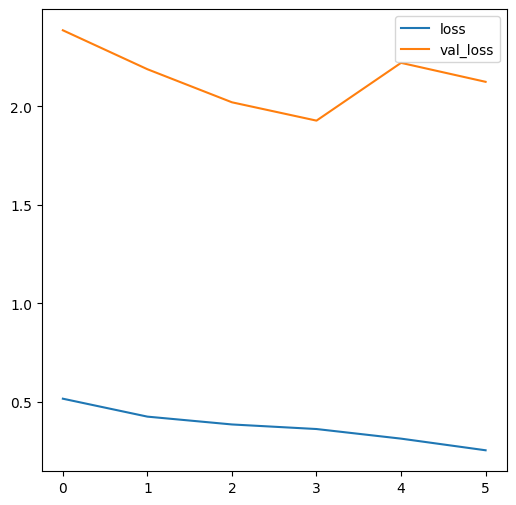

In [31]:
d[['loss','val_loss']].plot(figsize=(6,6))

In [32]:
model_LSTM.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 20, 45)              │           8,460 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 20, 45)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 16)                  │           3,968 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 16)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 3)                   │              51 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │               4 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 37,451 (146.30 KB)

 Trainable params: 12,483 (48.76 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 24,968 (97.54 KB)

In [33]:

y_pred

array([[0.47250187],
       [0.6708667 ],
       [0.4733893 ],
       [0.67148334],
       [0.47427765],
       [0.67209727],
       [0.47516122],
       [0.67270947],
       [0.47604308],
       [0.6733199 ],
       [0.4769219 ],
       [0.6739292 ],
       [0.47779953],
       [0.674537  ],
       [0.4786751 ],
       [0.67514324],
       [0.47954854],
       [0.6757482 ],
       [0.48042017],
       [0.6763511 ],
       [0.4812884 ],
       [0.67695326],
       [0.48215643],
       [0.677553  ],
       [0.4830205 ],
       [0.67815286],
       [0.48388517],
       [0.6787507 ],
       [0.48474678],
       [0.6793463 ],
       [0.48560506],
       [0.6799409 ],
       [0.4864624 ],
       [0.6805332 ],
       [0.48731592],
       [0.6811248 ],
       [0.48816898],
       [0.6817145 ],
       [0.4890188 ],
       [0.6823019 ],
       [0.48986545],
       [0.68288857],
       [0.490711  ],
       [0.68347436],
       [0.49155584],
       [0.68405807],
       [0.49239752],
       [0.684

In [34]:
y_pred.ndim

2

<Axes: >

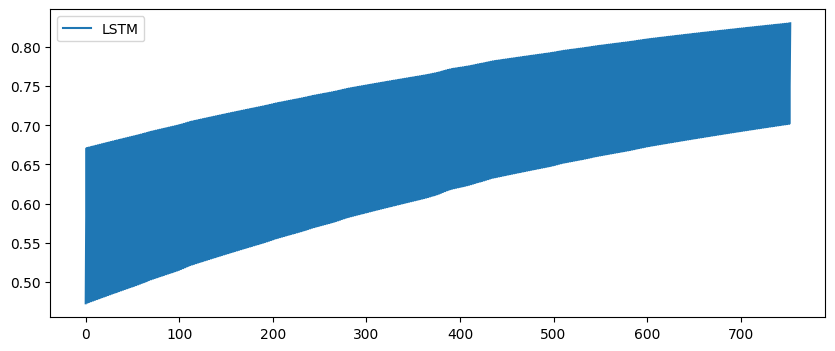

In [35]:

Pred = pd.DataFrame({"LSTM": y_pred.flatten()})  # flatten → 1D

Pred.head()


Pred.plot(figsize=(10,4))

In [36]:
print("y_pred.shape:", y_pred.shape)


y_pred.shape: (754, 1)


In [38]:
import os
from tensorflow.keras.models import save_model


folder = "../models"  
os.makedirs(folder, exist_ok=True)  
model_path = os.path.join(folder, "model_LSTM_forex.keras")
model_LSTM.save(model_path)


print(f"Model saved to {model_path}")


Model saved to ../models\model_LSTM_forex.keras


Recursive prediction

In [102]:
X[-1].ndim

2

In [108]:
last_sample = X[-1].copy()
last_sample = last_sample.reshape(1, 20, 1)
model_LSTM.predict(last_sample)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


array([[0.9335339]], dtype=float32)

In [109]:
last_sample = X[-1].copy()
last_sample = last_sample.reshape(1, 20, 1) 
preds = []
forecast_horizon = 30

for _ in range(forecast_horizon):  
    next_pred = model_LSTM.predict(last_sample)[0,0]
    preds.append(next_pred)

    last_sample = np.roll(last_sample, -1)  # shift left
    last_sample[-1] = next_pred            # append predicted value at the end



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━

In [113]:
import pandas as pd

forecast_df = pd.DataFrame({
    "Day": range(1, len(preds) + 1),
    "Forecast": preds
})

print(forecast_df.head(2))


   Day  Forecast
0    1  0.933534
1    2  1.895213


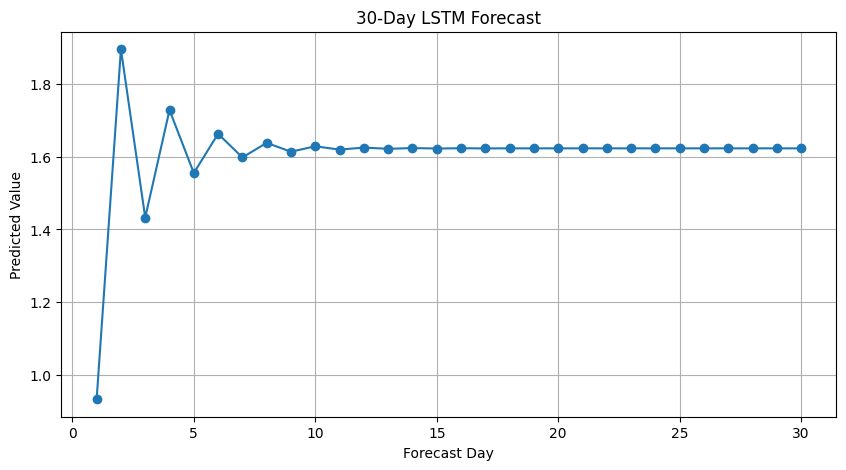

In [114]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(forecast_df["Day"], forecast_df["Forecast"], marker='o')
plt.xlabel("Forecast Day")
plt.ylabel("Predicted Value")
plt.title("30-Day LSTM Forecast")
plt.grid(True)
plt.show()
